# Kalman Filter for Spherical Codec

In this notebook, we shall implement a Kalman filter to show the inference performance. This notebook provides data and figures for the paper.

Prerequisites:

<ul>
    <li> Run the generate_dset.py to collect trajectories CSV.</li>
    <li> Run the trajectory_preprocessor.ipynb notebook to get the trajectory pyo file. This notebook trims and lengthens the trajectories. </li>
    <li> Run the get_config_for_spherix.ipynb notebook to get the spherixcfg.txt and .pyo file. The latter will be used in this notebook to import mean and basis functions. </li>
</ul>

In [49]:
import numpy as np 
from matplotlib import pyplot as plt 
import pickle

In [50]:
with open('spherixcfg.pyo', 'rb') as f:
    pyo_obj = pickle.load(f)
    mean_x = pyo_obj["mean"]
    basis_x = pyo_obj["basis"]

Text(0.5, 1.0, 'Basis components')

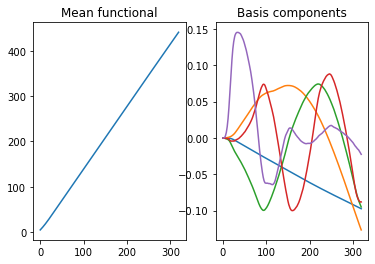

In [51]:
plt.subplot(121)
plt.plot(mean_x)
plt.title('Mean functional')
plt.subplot(122)
for i in range(basis_x.shape[0]):
    plt.plot(basis_x[i,:])
plt.title('Basis components')

Get an example trajectory from trajectories.pyo (the trace dataset) file

In [52]:
with open('trajectories.pyo', 'rb') as f:
    pyo_obj = pickle.load(f)
    y_vec = pyo_obj["y_vec"]
    x_vec = pyo_obj["x_vec"]
    t_vec = pyo_obj["t_vec"]

The trajectories in the dataset:

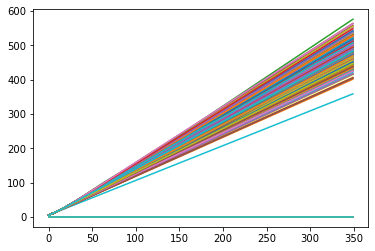

In [53]:
for i in range(y_vec.shape[0]):
    plt.plot(y_vec[i,:])

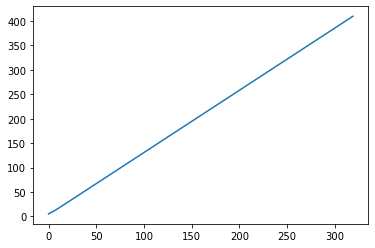

In [54]:
ex_traj = y_vec[69,:320] # the example trajectory
plt.plot(ex_traj)

In [55]:
import sys 
sys.path.append('../otqd/')

In [56]:
from otqd import OTQD

In [57]:
covar_a = np.diag([1.12661890e+05, 7.74671807e+02, 6.50847844e+01, 9.61364771e+00, 7.86367820e+00])
info_a = np.linalg.inv(covar_a)
mu_a = np.zeros((5,1))
var_e = 1
info_e2 = 1/var_e 

In [58]:
def get_prediction(mean, basis, mape, t):
    return mean[t] + (basis @ mape.reshape((-1,1)))[t]

tol_d = 6.0 # error tolerance until re-broadcast
n_broadcast = 0 # number of broadcast
otqd = OTQD(info_a, mu_a, info_e2, mean_x, basis_x.T, i_max = 1, i_spacing = 10, n_basis = 5)
traj_length = ex_traj.shape[0]
map_traj = np.zeros((traj_length, 5)) # MAP's trajectory during fusion
client_mape = np.zeros((5,1))
traj_client = np.zeros_like(ex_traj)
for i in range(traj_length):
    mape, mapvar = otqd.get_posteriori()
    y_hat = get_prediction(mean = mean_x, basis = basis_x.T, mape = client_mape, t=i)
    y = ex_traj[i]
    if np.abs(y_hat - y) > tol_d:
        print('Broadcast at t = {}'.format(i))
        client_mape = mape
    traj_client[i] = y_hat
    otqd.new_measurement(ex_traj[i]) # fuse new measurement
    mape, mapvar = otqd.get_posteriori()
    map_traj[i,:] = mape.reshape(-1)

Broadcast at t = 77


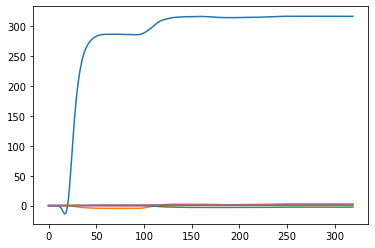

In [59]:
plt.plot(map_traj)

Text(0.5, 1.0, "Client's trajectory and actual trajectory")

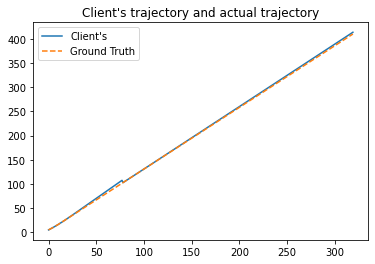

In [60]:
plt.plot(traj_client, label = 'Client\'s')
plt.plot(ex_traj[:320], '--', label='Ground Truth')
plt.legend()
plt.title('Client\'s trajectory and actual trajectory')